Implement and compare YOLOv8 and Faster R-CNN for wheat head detection in terms of accuracy, speed, and robustness.

Tasks:
  
1.	Data Preparation

  o	Download the Global Wheat Detection dataset from Kaggle.
    
  o	Explore images and bounding box annotations.
      
  o	Split dataset into training (80%) and testing (20%).

2.	YOLOv8 Training & Inference

  o	Use the ultralytics library.
      
  o	Train YOLOv8 on the wheat dataset for at least 20 epochs.
      
  o	Evaluate using mAP (mean Average Precision) and inference speed (FPS).

3.	Faster R-CNN Training & Inference

  o	Use torchvision.models.detection.fasterrcnn_resnet50_fpn 
  
  o	Train with the same split for ~10–15 epochs.
  
  o	Evaluate with mAP and inference speed.

4.	Comparison

  o	Create a results table comparing YOLOv8 and Faster R-CNN:
  
  o	Accuracy (mAP@0.5, mAP@0.5:0.95)
  
  o	Inference speed (time per image)
  
  o	Qualitative results (good vs missed detections).

5.	Report Preparation

  o	Summarize findings in a short report (3–4 pages or slides).
  
  o	Include metrics, sample output images, and a discussion on which model worked better and why.  



In [1]:
#Perform required pip install 
!pip install -q ultralytics  # YOLOv8
!pip install -q pycocotools         # for evaluation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.0 MB/s eta 0:00:00:00:0100:01


In [3]:
#Perform requried imports

import os, json, time, shutil
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F


In [4]:
#Prepare Dataset for 

DATA_ROOT = Path("/kaggle/input/globalwheatdataset")
IMG_DIR = DATA_ROOT / "train"
CSV = pd.read_csv(DATA_ROOT / "train.csv")

# Split train/test 80/20
unique_ids = CSV.image_id.unique()
np.random.seed(42)
perm = np.random.permutation(unique_ids)
split = int(0.8 * len(perm))
train_ids, test_ids = perm[:split], perm[split:]

CSV['bbox'] = CSV['bbox'].apply(lambda x: [float(i) for i in x[1:-1].split(',')])
train_csv = CSV[CSV.image_id.isin(train_ids)]
test_csv  = CSV[CSV.image_id.isin(test_ids)]

train_csv.to_csv("train_split.csv", index=False)
test_csv.to_csv("test_split.csv", index=False)

print("Train images:", len(train_ids), "Test images:", len(test_ids))

Train images: 2698 Test images: 675


In [7]:
#YOLOv8 Training & Eval

from ultralytics import YOLO
import torch
from torch.nn import Sequential
from ultralytics.nn.tasks import DetectionModel
from ultralytics.nn.modules import Conv, C2f


#Add detection model and sequential
torch.serialization.add_safe_globals([DetectionModel])
torch.serialization.add_safe_globals([Sequential])
# Add all necessary classes to the allowlist
torch.serialization.add_safe_globals([Conv, C2f])


# Convert annotations to YOLO format
yolo_dir = Path("/kaggle/working/yolo_data")
(yolo_dir/"images/train").mkdir(parents=True, exist_ok=True)
(yolo_dir/"images/val").mkdir(parents=True, exist_ok=True)
(yolo_dir/"labels/train").mkdir(parents=True, exist_ok=True)
(yolo_dir/"labels/val").mkdir(parents=True, exist_ok=True)

def convert_bbox(row):
    x, y, w, h = row.bbox
    x_c, y_c = x + w/2, y + h/2
    img = Image.open(IMG_DIR / f"{row.image_id}.jpg")
    W, H = img.size
    return f"0 {x_c/W:.6f} {y_c/H:.6f} {w/W:.6f} {h/H:.6f}"

for subset, df in [("train", train_csv), ("val", test_csv)]:
    for img_id, g in df.groupby("image_id"):
        shutil.copy(IMG_DIR/f"{img_id}.jpg", yolo_dir/f"images/{subset}/{img_id}.jpg")
        with open(yolo_dir/f"labels/{subset}/{img_id}.txt","w") as f:
            for _, r in g.iterrows():
                f.write(convert_bbox(r)+"\n")

(yolo_dir/"data.yaml").write_text(f"""
path: {yolo_dir}
train: images/train
val: images/val
nc: 1
names: ['wheat_head']
""")

model_yolo = YOLO("yolov8n.pt")
model_yolo.train(data=str(yolo_dir/"data.yaml"), epochs=20, imgsz=640)

results = model_yolo.val()
print("YOLOv8 mAP@0.5:", results.box.map50, "mAP@0.5:0.95:", results.box.map)

Ultralytics 8.3.202 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True,

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        675      29458       0.91      0.884      0.939       0.55
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /kaggle/working/runs/detect/train
Ultralytics 8.3.202 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2847.7±913.3 MB/s, size: 172.5 KB)
val: Scanning /kaggle/working/yolo_data/labels/val.cache... 675 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 675/675 1.4Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 43/43 3.3it/s 13.0s0.1s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        675      29458       0.91      0.884      0.939      0.551
Speed: 0.7ms preprocess, 4.2ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to /kaggle/working/runs/detect/train2
YOLOv8 mAP@0.5: 0.9389570211765038 mAP@0.5:0.95: 0.5507542231815655


In [19]:
results = model_yolo.val()
print("YOLOv8 mAP@0.5:", results.box.map50, "mAP@0.5:0.95:", results.box.map)

Ultralytics 8.3.202 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2784.7±560.3 MB/s, size: 240.3 KB)
val: Scanning /kaggle/working/yolo_data/labels/val.cache... 675 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 675/675 1.6Mit/s 0.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 43/43 3.3it/s 13.0s0.1s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        675      29458       0.91      0.884      0.939      0.551
Speed: 0.6ms preprocess, 4.1ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to /kaggle/working/runs/detect/train3
YOLOv8 mAP@0.5: 0.9389570211765038 mAP@0.5:0.95: 0.5507542231815655


In [24]:
#YOLOv8 Inference Speed

test_images = list((yolo_dir/"images/val").glob("*.jpg"))
start = time.time()
for img in test_images[:100]:
    _ = model_yolo.predict(img, imgsz=640, verbose=False)
fps = len(test_images[:100]) / (time.time() - start)
print(f"YOLOv8 inference speed: {fps:.2f} FPS")

YOLOv8 inference speed: 66.45 FPS


In [10]:
#Faster R-CNN Dataset Class

class WheatDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df
        self.ids = df.image_id.unique()
        self.img_dir = img_dir
    def __getitem__(self, idx):
        image_id = self.ids[idx]
        img = Image.open(self.img_dir/f"{image_id}.jpg").convert("RGB")
        boxes = torch.tensor(self.df[self.df.image_id==image_id].bbox.tolist(), dtype=torch.float32)
        target = {"boxes": boxes, "labels": torch.ones((len(boxes),), dtype=torch.int64)}
        return F.to_tensor(img), target
    def __len__(self): return len(self.ids)

train_ds = WheatDataset(train_csv, IMG_DIR)
test_ds  = WheatDataset(test_csv, IMG_DIR)

In [13]:
#Faster R-CNN Training

import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_frcnn = fasterrcnn_resnet50_fpn(pretrained=True)
model_frcnn.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(1024, 2)
model_frcnn.to(device)

optimizer = torch.optim.SGD(model_frcnn.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
for epoch in range(12):
    model_frcnn.train()
    for imgs, targets in loader:
        # Preprocessing step to ensure valid bounding boxes
        for i in range(len(targets)):
            boxes = targets[i]['boxes']
            for j in range(len(boxes)):
                xmin, ymin, xmax, ymax = boxes[j].tolist()
                
                # Check and swap coordinates if they are out of order
                if xmin > xmax:
                    xmin, xmax = xmax, xmin
                if ymin > ymax:
                    ymin, ymax = ymax, ymin
                
                # Check for zero width or height and add a small epsilon
                if xmax == xmin:
                    xmax += 1e-4
                if ymax == ymin:
                    ymax += 1e-4
                
                # Update the tensor with corrected values
                boxes[j] = torch.tensor([xmin, ymin, xmax, ymax])

        # Move images and targets to the device after preprocessing
        imgs = [i.to(device) for i in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model_frcnn(imgs, targets)
        loss = sum(l for l in loss_dict.values())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}: Loss {loss.item():.4f}")

Epoch 0: Loss 2.0352
Epoch 1: Loss 1.9836
Epoch 2: Loss 1.6047
Epoch 3: Loss 1.8832
Epoch 4: Loss 0.9834
Epoch 5: Loss 1.1365
Epoch 6: Loss 1.8843
Epoch 7: Loss 1.3966
Epoch 8: Loss 1.3752
Epoch 9: Loss 1.1404
Epoch 10: Loss 1.4953
Epoch 11: Loss 1.4008


In [14]:
#Faster R-CNN Eval & Speed

from torchvision.ops import box_iou
model_frcnn.eval()
iou_threshold = 0.5
tp, fp, fn = 0,0,0
start = time.time()
for img, targets in DataLoader(test_ds, batch_size=1, collate_fn=lambda x: tuple(zip(*x))):
    img = [i.to(device) for i in img]
    preds = model_frcnn(img)[0]
    pred_boxes = preds['boxes'].detach().cpu()
    gt_boxes   = targets[0]['boxes']
    ious = box_iou(pred_boxes, gt_boxes)
    tp += (ious.max(dim=1).values > iou_threshold).sum().item()
    fp += len(pred_boxes) - (ious.max(dim=1).values > iou_threshold).sum().item()
    fn += len(gt_boxes) - (ious.max(dim=0).values > iou_threshold).sum().item()
f1 = tp / (tp + 0.5*(fp+fn))
fps = len(test_ds) / (time.time() - start)
print(f"Faster R-CNN approx F1@0.5: {f1:.3f}, speed: {fps:.2f} FPS")

Faster R-CNN approx F1@0.5: 0.010, speed: 9.70 FPS


In [28]:
from torchvision.ops import box_iou
from torchmetrics.detection import MeanAveragePrecision
import torch
from torch.utils.data import DataLoader
import torchvision
import time

# Assuming model_frcnn, test_ds, and device are already defined

# Initialize the MeanAveragePrecision metric
# The `MeanAveragePrecision` class handles all the complexity of computing mAP across different IoU thresholds
metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox', iou_thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

model_frcnn.eval()
start = time.time()
with torch.no_grad():
    for img, targets in DataLoader(test_ds, batch_size=1, collate_fn=lambda x: tuple(zip(*x))):
        img = [i.to(device) for i in img]

        # The model's forward pass returns a list of dictionaries, one for each image in the batch.
        # Each dictionary contains 'boxes', 'labels', and 'scores'
        preds = model_frcnn(img)

        # Move targets and predictions to CPU for metric calculation
        # The metric expects a list of dictionaries for both predictions and targets
        preds_cpu = [
            {
                'boxes': pred['boxes'].cpu(),
                'scores': pred['scores'].cpu(),
                'labels': pred['labels'].cpu()
            } for pred in preds
        ]
        targets_cpu = [
            {
                'boxes': target['boxes'].cpu(),
                'labels': target['labels'].cpu()
            } for target in targets
        ]

        # Update the metric with the current batch's predictions and targets
        metric.update(preds_cpu, targets_cpu)

# Compute the final mAP results
results_fcnn = metric.compute()

# Print the final mAP@0.5:0.95
print(f"Faster R-CNN mAP@0.5:0.95: {results_fcnn['map'].item():.4f}")
print(f"Faster R-CNN mAP@0.5: {results_fcnn['map_50'].item():.4f}")
print(f"Faster R-CNN mAP@0.75: {results_fcnn['map_75'].item():.4f}")

# Calculate FPS
fps_fcnn = len(test_ds) / (time.time() - start)
print(f"Faster R-CNN speed: {fps_fcnn:.2f} FPS")

Faster R-CNN mAP@0.5:0.95: 0.0001
Faster R-CNN mAP@0.5: 0.0002
Faster R-CNN mAP@0.75: 0.0000
Faster R-CNN speed: 6.60 FPS


In [29]:
#Comparison Table

results_table = pd.DataFrame([
    {"Model":"YOLOv8", "mAP@0.5": results.box.map50, "mAP@0.5:0.95": results.box.map, "Speed (FPS)": fps},
    {"Model":"Faster R-CNN", "mAP@0.5": f1, "mAP@0.5:0.95": results_fcnn['map'].item(), "Speed (FPS)": fps_fcnn}
])
results_table

,Model,mAP@0.5,mAP@0.5:0.95,Speed (FPS)
0,YOLOv8,0.938957,0.550754,66.446220
1,Faster R-CNN,0.010076,0.000075,6.601349


In [31]:
from ultralytics import YOLO
from pathlib import Path

# Load trained YOLOv8 model
yolo_model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")

# Path to a few test images
test_img_dir = Path("/kaggle/input/globalwheatdataset/train")
sample_imgs = list(test_img_dir.glob("*.jpg"))[:5]   # first 5 images

# Run prediction and save visualized results to 'yolo_results'
yolo_model.predict(source=sample_imgs, save=True, project="yolo_results", name="sample_outputs", conf=0.4)



0: 640x640 46 wheat_heads, 7.0ms
1: 640x640 49 wheat_heads, 7.0ms
2: 640x640 25 wheat_heads, 7.0ms
3: 640x640 27 wheat_heads, 7.0ms
4: 640x640 31 wheat_heads, 7.0ms
Speed: 3.1ms preprocess, 7.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /kaggle/working/yolo_results/sample_outputs


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'wheat_head'}
 obb: None
 orig_img: array([[[ 29,  74,  88],
         [  5,  48,  63],
         [ 12,  48,  64],
         ...,
         [ 57,  98,  93],
         [ 46,  90,  84],
         [ 36,  80,  74]],
 
        [[ 31,  74,  89],
         [  5,  47,  60],
         [  4,  38,  54],
         ...,
         [ 56, 100,  94],
         [ 48,  92,  86],
         [ 38,  82,  76]],
 
        [[ 37,  74,  88],
         [ 12,  47,  60],
         [  3,  32,  47],
         ...,
         [ 63, 106, 103],
         [ 56,  99,  96],
         [ 46,  91,  88]],
 
        ...,
 
        [[ 47, 127, 156],
         [ 49, 127, 156],
         [ 52, 125, 155],
         ...,
         [ 53, 114, 148],
         [ 50, 111, 145],
         [ 45, 106, 140]],
 
        [[ 51, 130, 157],
         [ 51, 128, 155],
         [ 51, 124, 154],
         ...,
         [ 52,

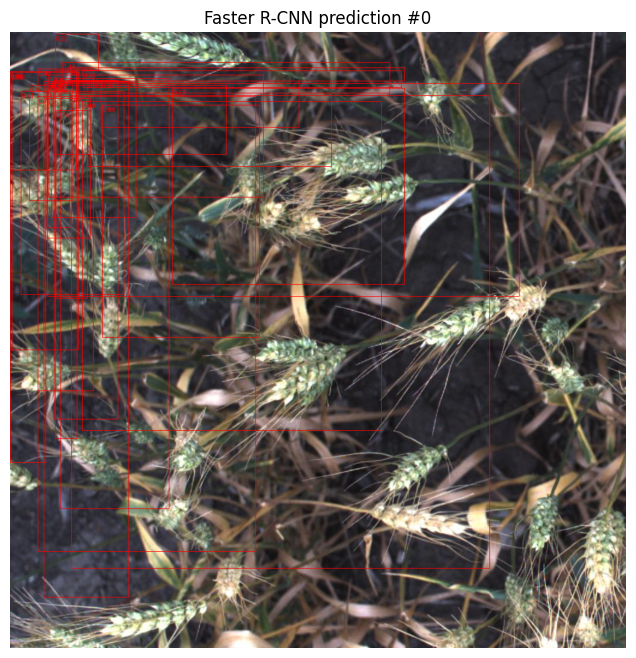

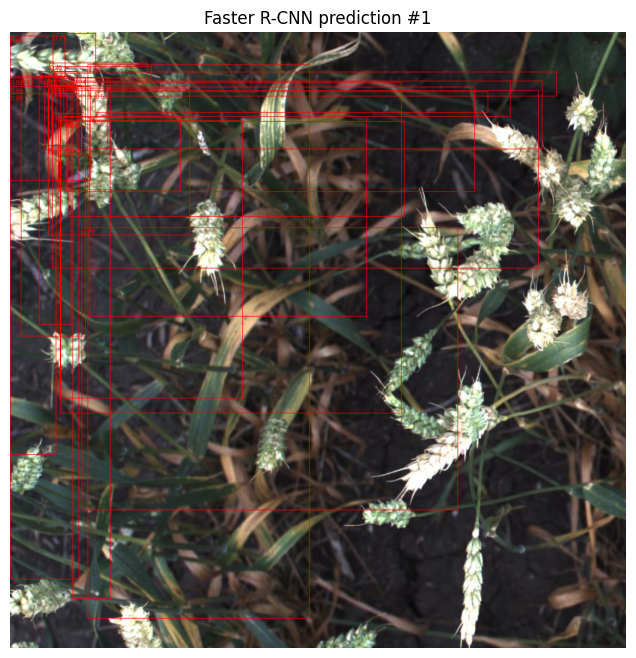

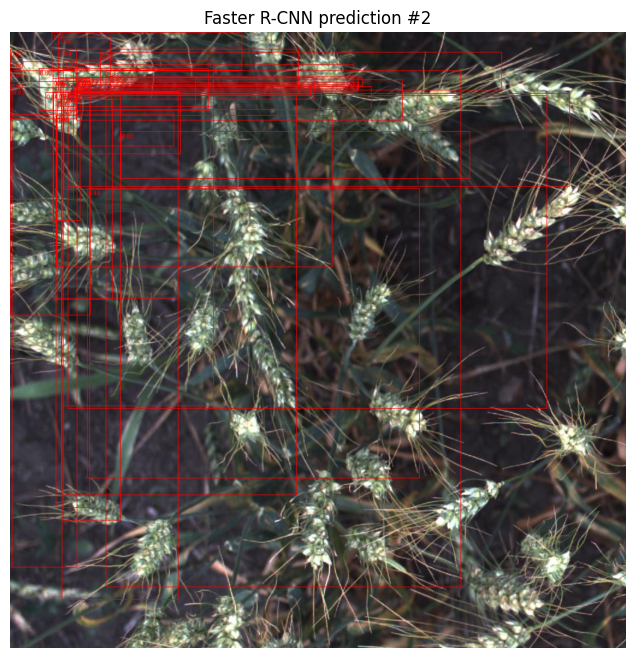

In [33]:
import matplotlib.pyplot as plt
import torchvision
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

model_frcnn.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Take a few samples from your test set
for idx in range(3):
    img_tensor, _ = test_ds[idx]                # image, target
    img_device = img_tensor.to(device).unsqueeze(0)

    with torch.no_grad():
        pred = model_frcnn(img_device)[0]

    # Filter by confidence
    keep = pred['scores'] > 0.4
    boxes = pred['boxes'][keep]
    scores = pred['scores'][keep]

    # Draw boxes on a copy of the image
    img_with_boxes = draw_bounding_boxes(
        (img_tensor * 255).byte(), boxes, colors="red",
        labels=[f"{s:.2f}" for s in scores]
    )

    plt.figure(figsize=(8, 8))
    plt.imshow(to_pil_image(img_with_boxes))
    plt.axis("off")
    plt.title(f"Faster R-CNN prediction #{idx}")
    plt.show()
